In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
from tqdm import tqdm
from PIL import Image
import os
import pickle

In [40]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        self.image_dirs = image_dirs
        self.transform = transform
        self.image_paths = []
        for image_dir in image_dirs:
            self.image_paths.extend([os.path.join(image_dir, fname) for fname in tqdm(os.listdir(image_dir))
                            if os.path.isfile(os.path.join(image_dir, fname))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        # print(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0

## Seed, Real bdd10k train and generated dataset represented with PCA in 3D

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
IMG_SIZE = 224

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(
    model.features,
    torch.nn.AdaptiveAvgPool2d((1, 1)),
    torch.nn.Flatten()
)
model = model.to(DEVICE).eval()

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_embeddings(dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            features = model(images.to(DEVICE))
            embeddings.append(features.squeeze().cpu().numpy())
    return np.vstack(embeddings)

gen_paths = ['data/generated_dataset/yolo_format/images/train']
real_paths = ['datasets/bdd16k/images/train']
seed_paths = ['data/seed_images/bdd_images']

real_dataset = CustomImageDataset(real_paths, transform=transform)
gen_dataset = CustomImageDataset(gen_paths, transform=transform)
seed_dataset = CustomImageDataset(seed_paths, transform=transform)

real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=BATCH_SIZE)
gen_loader = torch.utils.data.DataLoader(gen_dataset, batch_size=BATCH_SIZE)
seed_loader = torch.utils.data.DataLoader(seed_dataset, batch_size=BATCH_SIZE)

# 5. Извлечение признаков
gen_emb = extract_embeddings(gen_loader)
real_emb = extract_embeddings(real_loader)
seed_emb = extract_embeddings(seed_loader)

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


In [ ]:
# with open('data/images_embeddings/gen_emb.pkl', 'rb') as f:
#     gen_emb = pickle.load(f)
    
# with open('data/images_embeddings/real_emb.pkl', 'rb') as f:
#     real_emb = pickle.load(f)
    
# with open('data/images_embeddings/seed_emb.pkl', 'rb') as f:
#     seed_emb = pickle.load(f)

In [ ]:
# folder_path = 'data/images_embeddings'
# with open(os.path.join(folder_path, 'real_emb_densenet.pkl'), 'wb') as fout:
#     pickle.dump(real_emb, fout)
# with open(os.path.join(folder_path, 'seed_emb_densenet.pkl'), 'wb') as fout:
#     pickle.dump(seed_emb, fout)
# with open(os.path.join(folder_path, 'gen_emb_densenet.pkl'), 'wb') as fout:
#     pickle.dump(gen_emb, fout)

In [54]:
real_emb.shape

(15273, 1024)

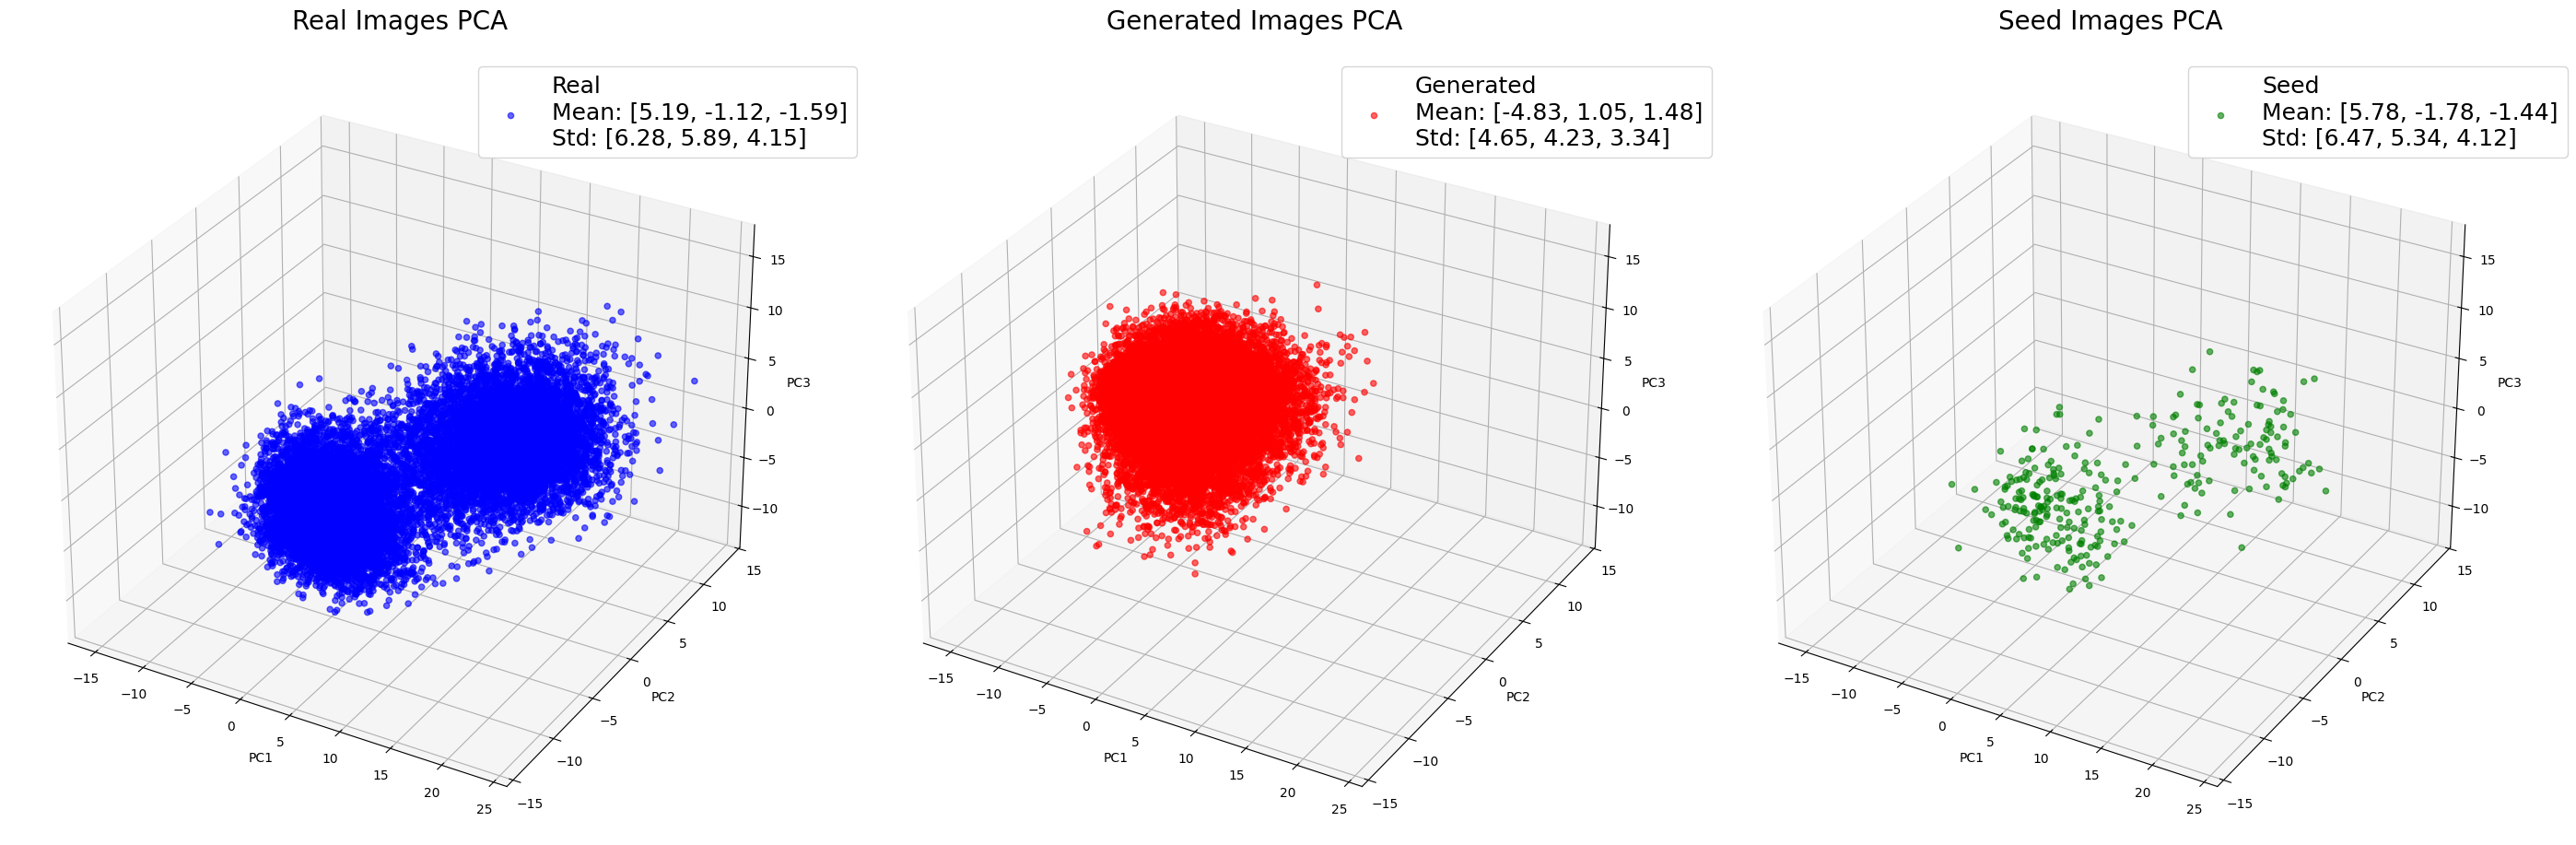


Подробные статистики:
Dataset | PC1 Mean | PC1 Std | PC2 Mean | PC2 Std | PC3 Mean | PC3 Std
------------------------------------------------------------------------------------------
Real | 5.19 | 6.28 | -1.12 | 5.89 | -1.59 | 4.15
Generated | -4.83 | 4.65 | 1.05 | 4.23 | 1.48 | 3.34
Seed | 5.78 | 6.47 | -1.78 | 5.34 | -1.44 | 4.12


In [ ]:
pca = PCA(n_components=3)
combined_emb = np.vstack([real_emb, gen_emb, seed_emb])
pca.fit(combined_emb)

real_pca = pca.transform(real_emb)
gen_pca = pca.transform(gen_emb)
seed_pca = pca.transform(seed_emb)

fig = plt.figure(figsize=(28, 9))

all_pca = np.vstack([real_pca, gen_pca, seed_pca])
x_lim = (all_pca[:,0].min()-1, all_pca[:,0].max()+1)
y_lim = (all_pca[:,1].min()-1, all_pca[:,1].max()+1)
z_lim = (all_pca[:,2].min()-1, all_pca[:,2].max()+1)

def get_stats_text(data, label):
    mean = data.mean(axis=0).round(2)
    std = data.std(axis=0).round(2)
    return (f"{label}\n"
            f"Mean: [{mean[0]:.2f}, {mean[1]:.2f}, {mean[2]:.2f}]\n"
            f"Std: [{std[0]:.2f}, {std[1]:.2f}, {std[2]:.2f}]")

# График для реальных данных (Real)
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(real_pca[:,0], real_pca[:,1], real_pca[:,2],
                 c='blue', alpha=0.6, label=get_stats_text(real_pca, "Real"))
ax1.set_title('Real Images PCA', pad=20, fontsize=20)
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)
ax1.set_zlim(z_lim)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend(handles=[sc1], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(gen_pca[:,0], gen_pca[:,1], gen_pca[:,2],
                 c='red', alpha=0.6, label=get_stats_text(gen_pca, "Generated"))
ax2.set_title('Generated Images PCA', pad=20, fontsize=20)
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_zlim(z_lim)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend(handles=[sc2], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(seed_pca[:,0], seed_pca[:,1], seed_pca[:,2],
                 c='green', alpha=0.6, label=get_stats_text(seed_pca, "Seed"))
ax3.set_title('Seed Images PCA', pad=20, fontsize=20)
ax3.set_xlim(x_lim)
ax3.set_ylim(y_lim)
ax3.set_zlim(z_lim)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.legend(handles=[sc3], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

plt.tight_layout()
plt.show()

print("\nПодробные статистики:")
print(f"{'Dataset'} | {'PC1 Mean'} | {'PC1 Std'} | {'PC2 Mean'} | {'PC2 Std'} | {'PC3 Mean'} | {'PC3 Std'}")
print("-" * 90)
for name, data in [('Real', real_pca), ('Generated', gen_pca), ('Seed', seed_pca)]:
    mean = data.mean(axis=0).round(2)
    std = data.std(axis=0).round(2)
    print(f"{name} | {mean[0]:.2f} | {std[0]:.2f} | {mean[1]:.2f} | {std[1]:.2f} | {mean[2]:.2f} | {std[2]:.2f}")

## Vendi Score

Реальные изображения

In [57]:
from vendi_score import vendi, image_utils

vendi.score_X(real_emb)

18.566185

Seed-изображения

In [58]:
vendi.score_X(seed_emb)

13.522772

Синтетические изображения

In [59]:
vendi.score_X(gen_emb)

16.72248

## FID (Frechet Inception Distance)

In [1]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [9]:
def load_images_to_tensor(folder_path, num_images=None):
    image_list = []
    transform = transforms.Compose([
        transforms.ToTensor(),  # Конвертирует в [0, 1]
        transforms.Resize((299, 299)),  # Размер для Inception-v3
    ])
    
    files = os.listdir(folder_path)[:num_images]  # Ограничение количества
    for file in tqdm(files):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(folder_path, file)).convert('RGB')
            img_tensor = transform(img)
            image_list.append(img_tensor)
    
    return torch.stack(image_list)

In [ ]:
real_test_images = load_images_to_tensor('datasets/bdd100k/images/test', num_images=16000)

100%|██████████| 16000/16000 [09:30<00:00, 28.03it/s]


In [ ]:
real_images = load_images_to_tensor('datasets/bdd16k/images/train')  # Пример: 1000 реальных
gen_images = load_images_to_tensor('data/generated_dataset/yolo_format/images/train')

100%|██████████| 16788/16788 [09:01<00:00, 31.03it/s]


FID gen train vs real train

In [ ]:
fid = FrechetInceptionDistance(feature=2048)

fid.update((real_images * 255).to(torch.uint8), real=True)
fid.update((gen_images * 255).to(torch.uint8), real=False)

fid_score = fid.compute()

In [17]:
fid_score

tensor(66.8776)

FID real train vs real test

In [21]:
fid = FrechetInceptionDistance(feature=2048)

    # Update the metric with real and generated image batches
fid.update((real_images * 255).to(torch.uint8), real=True)
fid.update((real_test_images * 255).to(torch.uint8), real=False)

# Compute the FID score
fid_score_real = fid.compute()

In [22]:
fid_score_real

tensor(5.9968)

Посчитаем долю объясненной вариации при PCA

In [60]:
pca = PCA(n_components=3)
pca.fit(real_emb)
print(sum(pca.explained_variance_ratio_))
pca.fit(gen_emb)
print(sum(pca.explained_variance_ratio_))

0.27300364524126053
0.20405766740441322


Оценим "мультяшность" генерируемых изображений с помощью величины градиента

In [ ]:
import cv2
import numpy as np
import random

def calculate_gradient_complexity(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(gx**2 + gy**2)
    return np.mean(magnitude)

real_dir = 'datasets/bdd16k/images/train'
real_paths = os.listdir(real_dir)
real_images = [cv2.imread(os.path.join(real_dir, filename)) for filename in tqdm(random.sample(real_paths, 1000))]

synt_dir = 'data/generated_dataset/yolo_format/images/train'
synt_paths = os.listdir(synt_dir)
synt_images = [cv2.imread(os.path.join(synt_dir, filename)) for filename in tqdm(random.sample(synt_paths, 1000))]

real_mags = []
for image in tqdm(real_images):
    mag = calculate_gradient_complexity(image)
    real_mags.append(mag)
    
synt_mags = []
for image in tqdm(synt_images):
    mag = calculate_gradient_complexity(image)
    synt_mags.append(mag)

100%|██████████| 1000/1000 [00:11<00:00, 87.68it/s]


In [10]:
np.mean(real_mags)

27.952802826111242

In [11]:
np.mean(synt_mags)

24.703712122405822